# LAB 5

The primary objective of this lab is to show how to use the
*rtweet* R package to collect data about tweets and Twitter 
users, and how to use the collected data to create graphs 
(social networks) of Twitter users in *igraph*.
The secondary objective is to demonstrate further the use 
of graph visualization R packages such as *visNetwork*.

### 1. SETUP

To be able to collect data from Twitter through the Twitter API
(https://developer.twitter.com/en/docs/twitter-api/v1)
you'll need to do the following things:

1) Set up a Twitter account, if you don’t already have one
(you do not need to be active on Twitter, just to have an account)

2) Install and load the following R packages: rtweet, httpuv, and tidyr

Note: **rtweets** GitHub repository offers lots of useful information on the front page:
https://github.com/ropensci/rtweet

In [1]:
# Install and load rtweet, httpuv, and tidyr R packages
# install.packages('rtweet')
# install.packages('httpuv')
# install.packages('tidyr')

In [2]:
library(rtweet)
library(httpuv)
library(tidyr)

We'll also install and load some additional 
R packages that we'll need for this lab:
- dplyr - for various data manipulation tasks (not specific to SNA)
- visNetwork - for creating interactive graph visualizations

In [3]:
# install.packages('visNetwork')
# install.packages('dplyr')
library(dplyr)
library(visNetwork)
library(igraph)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘igraph’


The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union


The following object is masked from ‘package:tidyr’:

    crossing


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union




### 2. SEARCH TWITTER AND COLLECT DATA FOR SETTING UP A NETWORK

In [4]:
?search_tweets

Note: ``search_tweets`` f. internally calls Twitter's [standard search API](https://developer.twitter.com/en/docs/twitter-api/v1/tweets/search/api-reference/get-search-tweets), parses the query results and returns them as a data frame. 

In [5]:
tweets <- search_tweets(q = "#InaugurationDay OR #InaugurationDay2021", type = 'recent', lang="en",
                        n = 15000, include_rts = FALSE, token = readRDS('rtweet_token.rds'))

# tweets <- search_tweets(q = "#ParisClimateAgreement OR #ParisClimateAccord", type = 'recent', lang="en",
#                         n = 15000, include_rts = FALSE, token = readRDS('rtweet_token.rds'))

Note: to more easily create complex queries, that is queries enabled by 
Twitter advanced search (https://twitter.com/search-advanced),
you can follow these guidelines:
https://help.twitter.com/en/using-twitter/twitter-advanced-search

In [6]:
# (optionally) save the results
# setwd("SNA_Labs")
saveRDS(tweets, 'data/InaugurationDay_29-01-2021.RData')

In [7]:
# load the saved data (for offline work)
# tweets <- readRDS("data/InaugurationDay_29-01-2021.RData")

In [8]:
# Get a glimpse into the obtained dataset
glimpse(tweets)

Rows: 6,654
Columns: 90
$ user_id                 <chr> "20917281", "1190227383225323522", "119022738…
$ status_id               <chr> "1355136626645749762", "1355048403454066689",…
$ created_at              <dttm> 2021-01-29 12:52:03, 2021-01-29 07:01:29, 20…
$ screen_name             <chr> "msretro", "okothvickymusic", "okothvickymusi…
$ text                    <chr> "Want one? Message me!\n•\n•\n•\n•\n#Bernie #…
$ source                  <chr> "Instagram", "Twitter for Android", "Twitter …
$ display_text_width      <dbl> 156, 274, 271, 271, 274, 271, 132, 118, 194, …
$ reply_to_status_id      <chr> NA, "1355013933887852544", "13526754857219645…
$ reply_to_user_id        <chr> NA, "1573440108", "3211045179", "133760010066…
$ reply_to_screen_name    <chr> NA, "HEBobiwine", "gichobikid", "Prettye92988…
$ is_quote                <lgl> FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, TRU…
$ is_retweet              <lgl> FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, FAL…
$ favorite_count          <i

For a detailed description of all the variables in the result set, see Twitter documentation for the Tweet object:<br>
https://developer.twitter.com/en/docs/twitter-api/v1/data-dictionary/object-model/tweet 


We will create "**mention networks**", that is networks with Twitter
users as nodes and connections (edges) established based on one
user mentioning another in his/her tweet. Mentioning can take the
form of direct replies or 'simple' mentions anywhere in the tweet's text.
So, we will have 2 networks: *reply_to* and *mentioned* networks. 

We will select only those columns (variables) that are relevant 
for creating "mention networks". We will also rename the selected 
columns, for the sake of having shorter variable names

In [9]:
tweets_users <- tweets %>%
  select(screen_name, reply_to_screen_name, mentions_screen_name) %>%
  rename(sender=screen_name, replied_to=reply_to_screen_name, mentioned=mentions_screen_name)

In [10]:
glimpse(tweets_users) 

Rows: 6,654
Columns: 3
$ sender     <chr> "msretro", "okothvickymusic", "okothvickymusic", "okothvic…
$ replied_to <chr> NA, "HEBobiwine", "gichobikid", "Prettye92988148", "david_…
$ mentioned  <list> [NA, "HEBobiwine", <"gichobikid", "kizzabesigye1", "Rapha…


Note that the mentioned column is a list; we will deal with it later.

Note also that many entries have missing values (NA) for the 'replied_to' and 'mentioned'
variables. Check how many such cases we have:

In [11]:
sum(is.na(tweets_users$replied_to))

sum(is.na(tweets_users$mentioned))

[1] 5525

[1] 3627

Keep only those tweets where the sender mentioned or replied to at least 
one other Twitter user

In [12]:
tweets_users <- tweets_users %>%
  filter( (is.na(replied_to)==FALSE) | (is.na(mentioned)==FALSE) )

In [13]:
nrow(tweets_users)
#View(tweets_users[1:10,])
tweets_users[1:10,]

[1] 3154

sender          replied_to     
1  okothvickymusic HEBobiwine     
2  okothvickymusic gichobikid     
3  okothvickymusic Prettye92988148
4  okothvickymusic david_serumaga 
5  okothvickymusic Prettye92988148
6  IshaxIsha       jodylynn_ri    
7  DCCelebrity     NA             
8  jayoung1892     NA             
9  jayoung1892     NA             
10 jayoung1892     NA             
   mentioned                                                                                                                                                                                     
1  HEBobiwine                                                                                                                                                                                    
2  gichobikid    , kizzabesigye1 , RaphaelMusembN, HEBobiwine                                                                                                                                    
3  Prettye92988148, BOBIJAWINE3    , kizzabesigye1  , RaphaelMusembN , HEBobiwine                                                                                                                
4  david_serumaga, OfwonoOpondo  , KagutaMuseveni, DuncanAbigaba , woira_michael , kyobesarah    , SolomonMGrace2, Muzukulu6     , SecuringUg    , CathyNamuddu  , twijukyeobed  , JackieRNMayega
5  Prettye92988148, BOBIJAWINE3    , kizzabesigye1  , RaphaelMusembN , HEBobiwine                                                                                                                
6  jodylynn_ri    , hopblooded     , SecondGentleman, ericgarland    , MerriamWebster                                                                                                            
7  BetoORourke, JoeBiden                                                                                                                                                                         
8  POTUS45                                                                                                                                                                                       
9  VP                                                                                                                                                                                            
10 USSenate, VP

Next, we will unnest the 'mentioned' column. 
Unnesting is the transformation of a list-column, so that each 
element of the list gets its own row.

In [14]:
?unnest

In [15]:
tweets_users <- unnest(tweets_users, mentioned) 
#View(tweets_users[1:20,])
tweets_users[1:20,]

sender          replied_to      mentioned      
1  okothvickymusic HEBobiwine      HEBobiwine     
2  okothvickymusic gichobikid      gichobikid     
3  okothvickymusic gichobikid      kizzabesigye1  
4  okothvickymusic gichobikid      RaphaelMusembN 
5  okothvickymusic gichobikid      HEBobiwine     
6  okothvickymusic Prettye92988148 Prettye92988148
7  okothvickymusic Prettye92988148 BOBIJAWINE3    
8  okothvickymusic Prettye92988148 kizzabesigye1  
9  okothvickymusic Prettye92988148 RaphaelMusembN 
10 okothvickymusic Prettye92988148 HEBobiwine     
11 okothvickymusic david_serumaga  david_serumaga 
12 okothvickymusic david_serumaga  OfwonoOpondo   
13 okothvickymusic david_serumaga  KagutaMuseveni 
14 okothvickymusic david_serumaga  DuncanAbigaba  
15 okothvickymusic david_serumaga  woira_michael  
16 okothvickymusic david_serumaga  kyobesarah     
17 okothvickymusic david_serumaga  SolomonMGrace2 
18 okothvickymusic david_serumaga  Muzukulu6      
19 okothvickymusic david_serumaga  SecuringUg     
20 okothvickymusic david_serumaga  CathyNamuddu

To create graphs, we need to transform our ``tweets_users`` data frame
into the format required by igraph's functions for graph construction. In particular, we will transform it into 2 edge lists: one for the 'reply_to' relation, and the other for the 'mentioned' relation.

First, create edge list for the 'reply_to' relation:

In [16]:
replied_to_edgelist <- tweets_users %>%
  select(-mentioned) %>%              # remove the 'mentioned' column
  filter(complete.cases(.)) %>%       # keep only complete rows, that is, rows without NAs
  group_by(sender, replied_to) %>%    # group the rows based on the sender, replied_to combination
  summarise(weight = n()) %>%         # compute the size of each group (i.e. number of connections 
  ungroup()                           # between each sender - replied_to pair) and assign it to the 
                                      # 'weight' variable

`summarise()` regrouping output by 'sender' (override with `.groups` argument)



In [17]:
head(replied_to_edgelist, n=10)

sender          replied_to     weight
1  13RiverSong     samriegel       1    
2  1dor            1dor            1    
3  2021Winer       DASimmigration 20    
4  2021Winer       JouryAli14      1    
5  2021Winer       MOoohamedArabi  5    
6  2shakethesystem JoeBiden        3    
7  5hearer3        tonyjamesworld  1    
8  6_rabbits       6_rabbits       2    
9  A81Bracks       BillClinton     1    
10 AAly37155637    VP              9

check the pairs with the most intensive communication: 

In [18]:
replied_to_edgelist %>%
  arrange(desc(weight)) %>%
  head(n=10)

sender          replied_to     weight
1  OhSoFrieda      OhSoFrieda     56    
2  Oliver29239048  POTUS          50    
3  RestlessNews    Robyn_CherCrew 50    
4  midomashkal92   DASimmigration 48    
5  SARA2001NOOR    Raymond_LLM    33    
6  Mina19376784    USEmbassyCairo 30    
7  Mina19376784    Mina19376784   28    
8  AdajeObiaboSund Sikika_Afrk    27    
9  midomashkal92   karimchao      27    
10 andytoronto     NMAAHC         23

In a similar way, create an edge list based on 'mentioned' relation

In [19]:
mentioned_edgelist <- tweets_users %>%
  select(-replied_to) %>%
  filter(complete.cases(.)) %>%
  group_by(sender, mentioned) %>%
  summarise(weight = n()) %>%
  ungroup()

`summarise()` regrouping output by 'sender' (override with `.groups` argument)



In [20]:
nrow(mentioned_edgelist)
head(mentioned_edgelist, n=10)

[1] 5571

sender         mentioned     weight
1  118thWing      WKRN          1     
2  13BrianFarrell SenSanders    1     
3  13BrianFarrell VBPD          1     
4  13BrianFarrell chrissyteigen 1     
5  13BrianFarrell johnlegend    1     
6  13BrianFarrell nick_sawhney  1     
7  13RiverSong    BernieSanders 1     
8  13RiverSong    samriegel     1     
9  16Ryanhunter   JoeBiden      1     
10 16Ryanhunter   MarkFWatts    1

examine most frequent mentions:

In [21]:
mentioned_edgelist %>%
  arrange(desc(weight)) %>%
  head(n=10)

sender          mentioned       weight
1  midomashkal92   POTUS           63    
2  midomashkal92   ABlinken        61    
3  midomashkal92   VP              60    
4  midomashkal92   PressSec        59    
5  Oliver29239048  POTUS           47    
6  rafiuddinfaroo4 FriedrichPieter 45    
7  Oliver29239048  VP              43    
8  Oliver29239048  PressSec        38    
9  Mina19376784    POTUS           36    
10 Mina19376784    ABlinken        35

Get the unique users in each edge list.
Those will be nodes in the corresponding networks.

Unique users in replied_to edgelist

In [22]:
reply_to_unique <- union(replied_to_edgelist$sender, replied_to_edgelist$replied_to)

the number of unique users (nodes in the network)

In [23]:
length(reply_to_unique)

[1] 1329

Unique users in mentioned edgelist

In [24]:
mention_unique <- union(mentioned_edgelist$sender, mentioned_edgelist$mentioned)
length(mention_unique)

[1] 4791

Considering the large number of unique users, that is, the number of
nodes in the prospective networks, it is worth examining options for 
filtering out some of them, in order to:
- reduce the 'noise' in the data,
- make the graphs easier to manipulate and analyse.

To decide on how to do the filtering, we'll examine the frequency 
of connections


In [25]:
summary(replied_to_edgelist$weight)
summary(mentioned_edgelist$weight)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00    1.00    2.00    3.22    3.00   56.00 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   1.000   1.318   1.000  63.000 

As there are too many users with loose connections 
(mentioned / replied_to just once),
keep only connections that are above the median.<br>
First for the mentioned edgelist:

In [26]:
mentioned_edgelist_reduced <- mentioned_edgelist %>%
  filter(weight > median(mentioned_edgelist$weight))

In [27]:
nrow(mentioned_edgelist_reduced)

[1] 530

Note a huge reduction in the size of the edgelist

Check again the number of unique users 

In [28]:
mention_unique <- union(mentioned_edgelist_reduced$sender, 
                         mentioned_edgelist_reduced$mentioned)
length(mention_unique)

[1] 424

It is also significantly reduced

Now, for the reply_to edge list:

In [29]:
replied_to_edgelist_reduced <- replied_to_edgelist %>%
  filter(weight > median(replied_to_edgelist$weight))

nrow(replied_to_edgelist_reduced)

[1] 315

Again, a notable reduction

Check again the number of unique users

In [30]:
reply_to_unique <- union(replied_to_edgelist_reduced$sender, 
                         replied_to_edgelist_reduced$replied_to)

length(reply_to_unique)

[1] 425

It is reduced but not as much as in the case of the 
mentioned relation (as expected)

Next, we'll collect users' data. These data can be used to describe nodes 
in networks, that is, to associate attributes to nodes.

First, we will collect data about the senders, since these data are available 
in the dataset we have already collected from Twitter (tweets data frame)


In [31]:
glimpse(tweets)

Rows: 6,654
Columns: 90
$ user_id                 <chr> "20917281", "1190227383225323522", "119022738…
$ status_id               <chr> "1355136626645749762", "1355048403454066689",…
$ created_at              <dttm> 2021-01-29 12:52:03, 2021-01-29 07:01:29, 20…
$ screen_name             <chr> "msretro", "okothvickymusic", "okothvickymusi…
$ text                    <chr> "Want one? Message me!\n•\n•\n•\n•\n#Bernie #…
$ source                  <chr> "Instagram", "Twitter for Android", "Twitter …
$ display_text_width      <dbl> 156, 274, 271, 271, 274, 271, 132, 118, 194, …
$ reply_to_status_id      <chr> NA, "1355013933887852544", "13526754857219645…
$ reply_to_user_id        <chr> NA, "1573440108", "3211045179", "133760010066…
$ reply_to_screen_name    <chr> NA, "HEBobiwine", "gichobikid", "Prettye92988…
$ is_quote                <lgl> FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, TRU…
$ is_retweet              <lgl> FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, FAL…
$ favorite_count          <i

Extract the data for all the senders, regardless of the type of relation
they established with alters (mentioned, replied_to). 

In [32]:
all_senders <- union(mentioned_edgelist_reduced$sender, 
                     replied_to_edgelist_reduced$sender)

senders_data <- tweets %>%
  filter(screen_name %in% all_senders) %>%  
  users_data() %>%                          # rtweet's function that pulls user data from a dataset of tweets
  distinct(user_id, .keep_all = TRUE)       # keep just distinct users (distinguish users based on user_id) 

check the kind of user data that is available

In [33]:
glimpse(senders_data)

Rows: 341
Columns: 20
$ user_id                <chr> "1190227383225323522", "627773541", "235953717…
$ screen_name            <chr> "okothvickymusic", "IshaxIsha", "jayoung1892",…
$ name                   <chr> "Okoth Vicky", "Isha\U0001f538Isha", "Mighty J…
$ location               <chr> "Nairobi, Kenya", "LAND of the FREEstyle", "Ma…
$ description            <chr> "Musician and Music producer", "Cultural Comme…
$ url                    <chr> NA, NA, "https://t.co/gfgGNRBR0G", "https://t.…
$ protected              <lgl> FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, FALS…
$ followers_count        <int> 33, 944, 20737, 1812, 1305, 45, 4374, 13807, 1…
$ friends_count          <int> 96, 388, 22793, 285, 1225, 155, 200, 3641, 238…
$ listed_count           <int> 0, 372, 94, 618, 67, 0, 77, 279, 16, 404, 0, 0…
$ statuses_count         <int> 2739, 46515, 587165, 32922, 18130, 215, 4887, …
$ favourites_count       <int> 870, 11042, 361124, 432, 6307, 118, 3144, 1214…
$ account_created_at     <dttm

Now, collect data for alters (mentioned / replied_to) - these are not necessarily
available in the collected tweets data, but have to be obtained separately.

First, identify the alters (users) for whom the data are not available

In [34]:
no_data_alters <- setdiff(union(mentioned_edgelist_reduced$mentioned, 
                                replied_to_edgelist_reduced$replied_to), all_senders)
length(no_data_alters)

[1] 361

Collect data for these users (no_data_alters) from Twitter. 
To that end, we will use the lookup_users function from rtweet package

In [ ]:
?lookup_users

In [35]:
alters_data <- lookup_users(no_data_alters, token = readRDS('rtweet_token.rds'))

save the data

In [36]:
saveRDS(alters_data, "data/raw_alters_data_29-01-2021.RData")

In [ ]:
# load the saved data (for offline work)
# alters_data <- readRDS("data/raw_alters_data_29-01-2021.RData")

In [37]:
glimpse(alters_data)

Rows: 357
Columns: 90
$ user_id                 <chr> "635716830", "1349149096909668363", "13491702…
$ status_id               <chr> "1351277868395991040", "1354953657796722693",…
$ created_at              <dttm> 2021-01-18 21:18:44, 2021-01-29 00:45:00, 20…
$ screen_name             <chr> "ABlinken", "POTUS", "PressSec", "VP", "Chail…
$ text                    <chr> "On this #MLKDay2021 and #DayOfService, Dr. K…
$ source                  <chr> "Twitter for iPhone", "The White House", "Twi…
$ display_text_width      <int> NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, NA, N…
$ reply_to_status_id      <chr> NA, NA, NA, NA, NA, NA, NA, NA, "135491700137…
$ reply_to_user_id        <chr> NA, NA, NA, NA, NA, NA, NA, NA, "14260960", N…
$ reply_to_screen_name    <chr> NA, NA, NA, NA, NA, NA, NA, NA, "JustinTrudea…
$ is_quote                <lgl> FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, FAL…
$ is_retweet              <lgl> FALSE, FALSE, TRUE, TRUE, FALSE, TRUE, TRUE, …
$ favorite_count          <int

In addition to user data, the ``lookup_users()`` f. also returned users' tweets.
However, we need only user data:

In [38]:
alters_data <- users_data(alters_data)

We should also check if we managed to retrieve data for all the users that 
we were interested in (the service may not return all the requested data)

In [39]:
missing_alter <- setdiff(no_data_alters, alters_data$screen_name)
length(missing_alter)

[1] 4

In case of missing user data, drop those users from the edge lists 
before saving those edge lists to files (see below).

Since we have done a lot of relevant processing steps, it would be wise to save 
the created edge lists and user attributes, so that we do not have to repeat the
processing steps.
Before saving edge lists, rename columns to the typical names used in edge lists

In [40]:
mentioned_edgelist_reduced %>%
  filter(!mentioned %in% missing_alter) %>%
  rename(ego=sender, alter=mentioned, mention_tie=weight) %>%
  saveRDS(file = "data/mentions_edgelist_29-01-2020.RData")

In [41]:
replied_to_edgelist_reduced %>%
  filter(!replied_to %in% missing_alter) %>%
  rename(ego=sender, alter=replied_to, reply_to_tie=weight) %>%
  saveRDS(file = "data/replied_to_edgelist_29-01-2020.RData")

Merge all available user data and store it in a file

In [42]:
senders_data %>%
  rbind(alters_data) %>%
  saveRDS("data/user_data_29-01-2020.RData")

Do the clean up, that is, remove all objects from the environment, 
we won't need them any more

In [43]:
remove(list = ls())

### 3. CREATE NETWORKS OF TWITTER USERS

Load data (edge list) for creating a network based on the 'mentioned' relation

In [44]:
mention_edgelist <- readRDS("data/mentions_edgelist_29-01-2020.RData")
glimpse(mention_edgelist)

Rows: 528
Columns: 3
$ ego         <chr> "2021Winer", "2021Winer", "2021Winer", "2021Winer", "2021…
$ alter       <chr> "ABlinken", "DASimmigration", "POTUS", "PressSec", "VP", …
$ mention_tie <int> 4, 4, 5, 5, 5, 3, 6, 6, 3, 2, 2, 2, 6, 2, 2, 7, 9, 3, 9, …


Create a directed network

In [45]:
mention_net <- graph_from_data_frame(mention_edgelist)
summary(mention_net)

IGRAPH 218b4db DN-- 420 528 -- 
+ attr: name (v/c), mention_tie (e/n)


Obviously very sparse network; let's check its density

In [46]:
edge_density(mention_net)

[1] 0.003000341

We can try to plot the graph

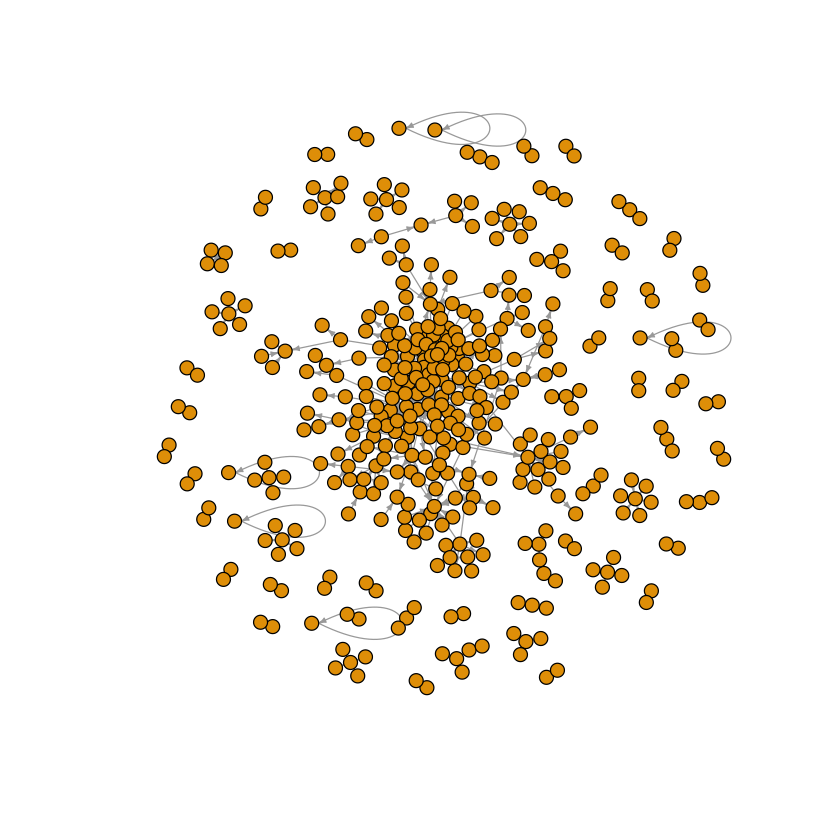

In [47]:
plot(mention_net, 
     layout = layout_with_graphopt(mention_net),
     edge.arrow.size=0.3,
     vertex.size = 5,
     vertex.label = NA)

We will get back to the plotting task a bit later.

Let's add attributes to nodes, and use these to better understand the network.
For example, we can include the number of followers, friends, and tweets.
To that end, we will create a function that receives: 

1) Twitter user data (as returned by the rtweet's ``users_data()`` f.), 

2) a vector of screen names of those users we are interested in.

The function returns a data frame with four variables (columns):
screen_name, followers_count, friends_count, and statuses_count

In [48]:
get_user_attrs <- function(twitter_user_data, users_screen_names) {
  twitter_user_data %>%
    filter(screen_name %in% users_screen_names) %>%
    select(screen_name, followers_count, friends_count, statuses_count)
}

Load the user data, required for adding attributes to the nodes

In [49]:
user_data <- readRDS("data/user_data_29-01-2020.RData")

Extract the set of attributes we are interested in 

In [50]:
node_attrs <- get_user_attrs(user_data, V(mention_net)$name)
glimpse(node_attrs)

Rows: 420
Columns: 4
$ screen_name     <chr> "okothvickymusic", "jayoung1892", "EverydayWomenJ", "…
$ followers_count <int> 33, 20737, 1812, 1305, 45, 4374, 13807, 1845, 33733, …
$ friends_count   <int> 96, 22793, 285, 1225, 155, 200, 3641, 2389, 49, 494, …
$ statuses_count  <int> 2739, 587165, 32922, 18130, 215, 4887, 28274, 15381, …


Sort ``node_attrs`` based on the username (screen_name), to match the order of vertex name attribute in the graph 

In [51]:
node_attrs <- arrange(node_attrs, screen_name) 

In [52]:
head(node_attrs, n=10)

screen_name  followers_count friends_count statuses_count
1  2021Winer         231         446            1885        
2  30seconds       28963        6264          210406        
3  6_rabbits         474         821            1604        
4  9GAG         16822656          10           51655        
5  AAly37155637       19          24             335        
6  ABC          16436203         516          333917        
7  ABC7News       170781        1204          374097        
8  ABCNetwork     692877         575           27211        
9  ABCWorldNews  1497230         448          181761        
10 ABlinken       323904         870            2097

Check the summary stats for the node attributes:

In [53]:
summary(node_attrs[,-1])

 followers_count     friends_count      statuses_count  
 Min.   :        0   Min.   :     0.0   Min.   :     1  
 1st Qu.:      420   1st Qu.:   200.8   1st Qu.:  2329  
 Median :     5126   Median :   766.0   Median : 10984  
 Mean   :  2425478   Mean   :  3790.6   Mean   : 42689  
 3rd Qu.:   301812   3rd Qu.:  2377.8   3rd Qu.: 41089  
 Max.   :109283883   Max.   :163782.0   Max.   :645823  

Create graph with node attributes

In [54]:
mention_net <- graph_from_data_frame(mention_edgelist, 
                                     vertices = node_attrs)

summary(mention_net)

IGRAPH 6b392be DN-- 420 528 -- 
+ attr: name (v/c), followers_count (v/n), friends_count (v/n),
| statuses_count (v/n), mention_tie (e/n)


Let's now make use of the vertex attributes to better understand the graph.

We'll make the size of the nodes proportional to the number of followers and 
use color to reflect the number of posted tweets (statuses)

Create gradient color vector based on the number of friends:

In [55]:
source('SNA_custom_functions.R')
posts_for_color <- attr_based_color_gradient(log1p(V(mention_net)$statuses_count), 
                                               c('grey100','midnightblue'))

Create a vector for node sizes, based on the number of followers

In [56]:
followers_for_size <- log1p(V(mention_net)$followers_count)

Note that we've used logged values of both the friend_count and followers_count 
vectors due to the very uneven distribution of values of these two attributes 
(plot the density functions of these attributes to see the distribution)

Now, draw a plot

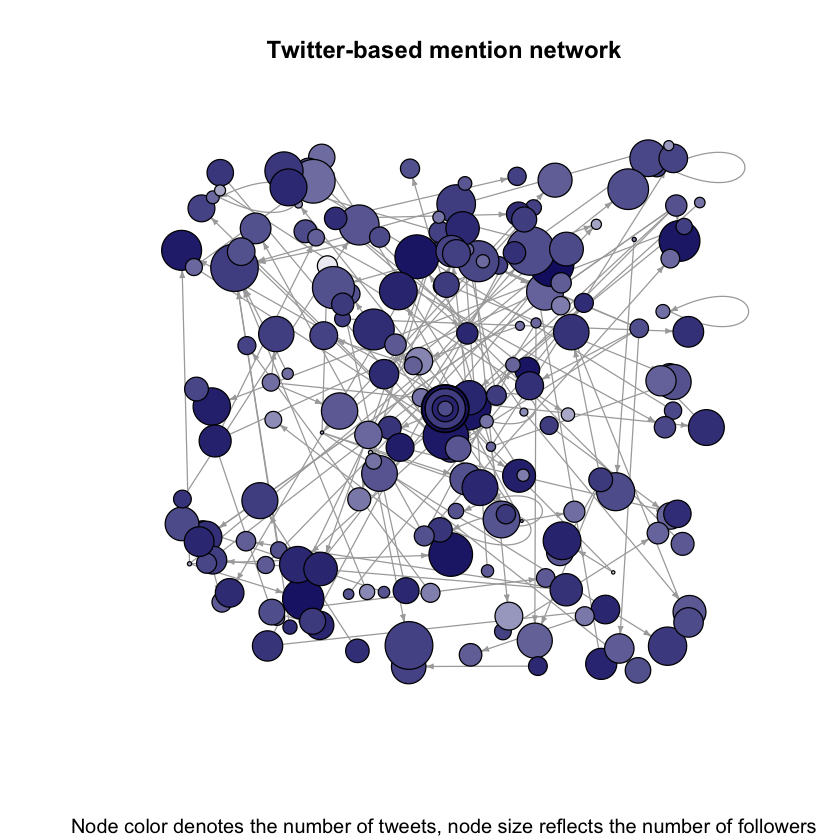

In [69]:
plot(mention_net, 
     layout = layout_with_lgl(mention_net),
     edge.arrow.size=0.3, 
     vertex.label = NA,
     vertex.size = followers_for_size,
     vertex.color = posts_for_color,
     main = "Twitter-based mention network",
     sub= "Node color denotes the number of tweets, node size reflects the number of followers")

#### TASK: 
Follow the above procedure to create and visualise a graph based on the reply_to connection

If the overall graph is overly large for meaningful visualization, we can take its giant component and create its visualization.

To find the giant component, we start by identifying components (subgraphs) in the graph. <br>
Due to the sparsity of edges, we won't be able to identify 'strong' components, 
so, we will opt for 'weak' components (reminder: for 'strong' components, the 
directionality of edges is considered; for detection of 'weak' components, the 
direction of edges is disregarded)

In [58]:
m_net_comp <- components(mention_net, mode = 'weak')
str(m_net_comp)

List of 3
 $ membership: Named num [1:420] 1 1 1 1 1 2 1 3 4 1 ...
  ..- attr(*, "names")= chr [1:420] "2021Winer" "30seconds" "6_rabbits" "9GAG" ...
 $ csize     : num [1:68] 231 7 5 3 2 2 2 4 3 2 ...
 $ no        : int 68


Identify the largest (gigantic) component:

In [59]:
giant_comp_size <- max(m_net_comp$csize)
giant_comp_size

[1] 231

In [60]:
giant_comp_index <- which(m_net_comp$csize == giant_comp_size)

Get ids of nodes that belong to the gigantic component:

In [61]:
nodes_in_gc <- which(m_net_comp$membership==giant_comp_index)

Next, extract the giant component from the ``mention_net`` graph. 
To that end, we will use ``induced_subgraph`` function.

In [ ]:
?induced_subgraph

In [62]:
giant_comp <- induced_subgraph(mention_net, vids = nodes_in_gc)

In [63]:
summary(giant_comp)
is_connected(giant_comp, mode = 'weak')

IGRAPH f12e70a DN-- 231 400 -- 
+ attr: name (v/c), followers_count (v/n), friends_count (v/n),
| statuses_count (v/n), mention_tie (e/n)


[1] TRUE

Now, plot the giant component using igraph's plotting features. 
Use the same kind of mapping between nodes' attributes 
(statuses_count and followers_count) and their visual representation 
(color and size, respectively)

In [64]:
gc_colors <- attr_based_color_gradient(log1p(V(giant_comp)$statuses_count), 
                                       c('grey100','midnightblue'))

In [65]:
gc_size <- log1p(V(giant_comp)$followers_count)

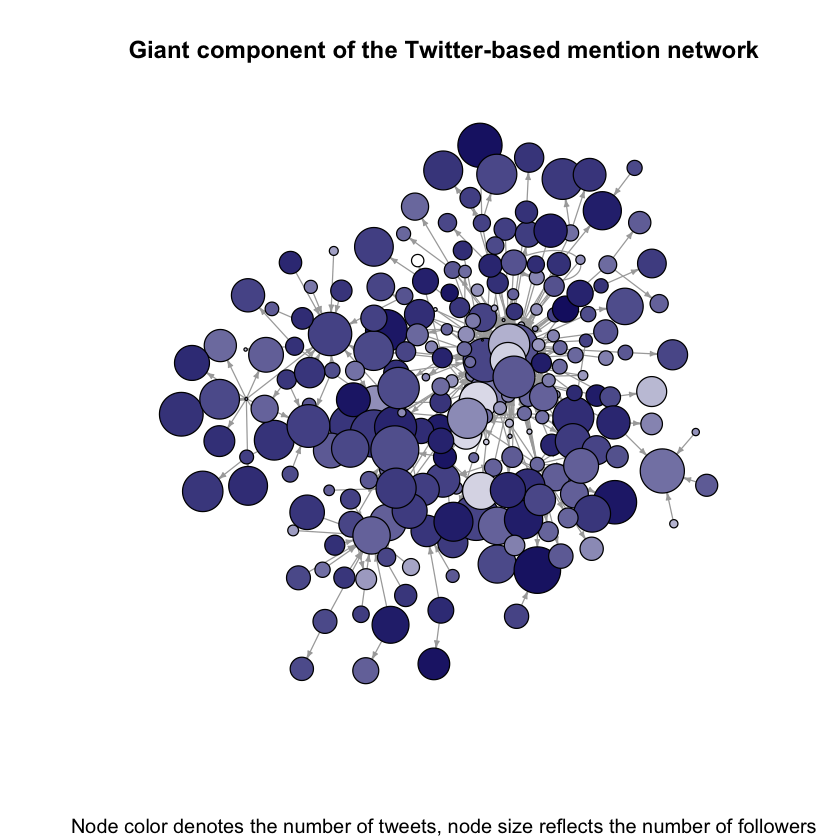

In [68]:
set.seed(2501)
plot(giant_comp, 
     layout = layout_with_lgl(giant_comp),
     edge.arrow.size=0.3, 
     vertex.label = NA,
     vertex.size = gc_size,
     vertex.color = gc_colors,
     main = "Giant component of the Twitter-based mention network",
     sub="Node color denotes the number of tweets, node size reflects the number of followers")

To try to get a better insight into the network, we will use interactive plots of the
*visNetwork* R package.

### 4. VISUALISE NETWORKS OF TWITTER USERS USING VISNETWORK

Note: for a tutorial on *visNetwork* and examples of use, see:
- Introduction to visNetwork, at:
  https://cran.r-project.org/web/packages/visNetwork/vignettes/Introduction-to-visNetwork.html 
- visNetwork documentation:
  http://datastorm-open.github.io/visNetwork/ 
- Section 6.2 of the 'Network visualization with R' tutorial, available at:
  http://kateto.net/network-visualization

As a minimum for graph visualization, visNetwork requires:
- nodes data frame, with 'id' column (plus any additional columns with node attributes)
- edges data.frame, with 'from' and 'to' columns (plus any additional columns with edge attributes)

Let's create those two (minimal) data frames

Note: if your network is overly large for a meaningful visualisation, visualise the gigantic component (giant_comp) instead

In [76]:
nodes_df <- data.frame(id=V(giant_comp)$name, # use V(mention_net)$name if visualising the entire mention network
                       stringsAsFactors = FALSE)
head(nodes_df)

id          
1 2021Winer   
2 30seconds   
3 6_rabbits   
4 9GAG        
5 AAly37155637
6 ABC7News

In [77]:
edges_df <- data.frame(as_edgelist(giant_comp), # use as_edgelist(mention_net) if visualising the entire mention network
                       stringsAsFactors = FALSE)
colnames(edges_df) <- c('from', 'to')
head(edges_df)

from      to            
1 2021Winer ABlinken      
2 2021Winer DASimmigration
3 2021Winer POTUS         
4 2021Winer PressSec      
5 2021Winer VP            
6 30seconds Chailey88

Now, we can create the simplest visualisation with visNetwork

In [78]:
visNetwork(nodes = nodes_df, 
           edges = edges_df, 
           main="Twitter-based mention network")

HTML widgets cannot be represented in plain text (need html)

Extend the nodes data frame with columns defining node color and size <br>
Note: see ``visNodes`` for column naming rules

In [79]:
nodes_df$color <- gc_colors # use posts_for_color if visualizing the entire mention_net
nodes_df$size <-  gc_size * 2 # use followers_for_size if visualizing the entire mention_net
head(nodes_df)

id           color   size     
1 2021Winer    #8181B0 10.893475
2 30seconds    #2B2B7B 20.547618
3 6_rabbits    #8484B2 12.326630
4 9GAG         #45458B 33.276474
5 AAly37155637 #A1A1C5  5.991465
6 ABC7News     #212175 24.096286

Extend the edges data frame with columns defining edge width, color, 
if it is curvy or not, and if / how arrows are displayed.<br>
Note: see ``visEdges`` for column naming and available options

In [80]:
edges_df$width <- 1 + (E(giant_comp)$mention_tie / 2) # use E(mention_net)$mention_tie if visualizing the entire mention_net
edges_df$color <- 'slategray3'
edges_df$smooth <- TRUE # should the edges be curved?
edges_df$arrows <- 'to'
head(edges_df)

from      to             width color      smooth arrows
1 2021Winer ABlinken       3.0   slategray3 TRUE   to    
2 2021Winer DASimmigration 3.0   slategray3 TRUE   to    
3 2021Winer POTUS          3.5   slategray3 TRUE   to    
4 2021Winer PressSec       3.5   slategray3 TRUE   to    
5 2021Winer VP             3.5   slategray3 TRUE   to    
6 30seconds Chailey88      2.5   slategray3 TRUE   to

In [81]:
visNetwork(nodes = nodes_df, 
           edges = edges_df, 
           main="Twitter-based mention network",
           footer = "Node color denotes the number of tweets, node size reflects the number of followers")

HTML widgets cannot be represented in plain text (need html)

Let's add a few additional details for node display:

In [82]:
nodes_df$title  <- nodes_df$id  # text to be displayed on mouse over 
nodes_df$borderWidth <- 1.5     # node border width

Instead of one color for a node, we can specify different colors 
for different parts of a node (main body and border) and different interaction states.<br>
First, remove the existing coor attribute

In [83]:
nodes_df <- nodes_df %>% select(-color)

Then, add new color-related attributes

In [84]:
nodes_df$color.background <- gc_colors # use posts_for_color if visualizing the entire mention_net
nodes_df$color.border <- "black"
nodes_df$color.highlight.background <- "orange" # color of the main body of a node when clicked
nodes_df$color.highlight.border <- "darkred"    # color of the border when a node is clicked

Run the visualization with the new parameters set

In [85]:
visnet <- visNetwork(nodes = nodes_df, 
                     edges = edges_df, 
                     main="Twitter-based mention network",
                     footer = "Node color denotes the number of tweets, 
                                node size reflects the number of followers")
visnet

HTML widgets cannot be represented in plain text (need html)

In [ ]:
# To see the various node attributes that can be used, check:
?visNodes

In [ ]:
# Similarly, for the recognised edge-related attributes, see
?visEdges

visNetwork offers a number of other options available through 
the ``visOptions()`` function. <br>For instance, we can highlight all 
direct neighbors and those 2 hops away:

In [86]:
visnet2 <- visOptions(visnet, 
                      highlightNearest = list(enabled = TRUE, degree = 2))
visnet2

HTML widgets cannot be represented in plain text (need html)

In [ ]:
# explore other visOptions
?visOptions

In [ ]:
# To examine the available layout options
?visLayout

In [ ]:
visLayout(visnet, randomSeed = 2021, improvedLayout = TRUE)

#### TASK: 
Follow the above procedure to create and visualise - using *visNetwork* - the graph based on the reply_to relation (or its giant component)